In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from selenium import webdriver as wb
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import datetime
import time
from wordcloud import WordCloud

## 비트코인과 안정자산, 위험자산의 상관관계 분석
- 데이터 산출 기간
    - 제도 편입 전 : 2014.09.01 ~ 2019.12.31
    - 제도 편입 후 : 2021.01.01 ~ 2024.06.06
- 안전자산 비교군 : 금, 달러
- 위험자산 비교군 : 원유
- 데이터 출처 : Yahoo Finance

In [2]:
# 기간
start_date = "2014-09-01"
end_date = "2019-12-31"
news_date_list = []

# 종목
bitcoin = "BTC-USD"
gold = "GC=F"
usd = "EURUSD=X"
wti = "CL=F"

# 일간 티커 데이터 수집
def ticker_data(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de)
    result["change"] = result["Adj Close"].diff()
    result["daily_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna() # NaN 포함 행 삭제
    return result

# 주간 티커 데이터 수집
def ticker_data_wk(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de, interval = "1wk")
    result["weekly_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna()
    return result

# 일별 수정 종가 (Adj Close) 추출 함수
def daily_adj_close(tk_name, ds, de) :
    result = yf.download(tk_name, ds, de)
    return result["Adj Close"]

# 일별 수익률 (daily_return) 추출 함수
def daily_return_rate(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de)
    return result["daily_return"]

# 주간 수익률 (weekly_return) 추출 함수
def weekly_return_rate(tk_name, ds, de) :
    result = ticker_data_wk(tk_name, ds, de)
    return result["weekly_return"]

# 비트코인과 티커 간의 상관성 산출
def corr_bit(tk_name, ds, de) :
    result = weekly_return_rate("BTC-USD", ds, de) / weekly_return_rate(tk_name, ds, de)
    result = result.dropna()
    return result

# 계산식 for 선형 회귀
def lin_cal(tk_name, ds, de) :
    tk2019 = ticker_data(tk_name, ds, de) # 제도 편입 후 기간의 티커 데이터 수집
    std2019 = tk2019[tk2019.index == "2019-11-15"] # 기준이 되는 날짜의 행 추출
    std2019 = std2019["Adj Close"].values[0] # 해당 행의 수정 종가
    result = (ticker_data(tk_name, ds, de)["Adj Close"] / std2019) * 100 # 티커의 수정 종가 컬럼과 연산
    return result

# 티커 생성 시 호출 함수
def ticker_call(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de) # 일간 티커 데이터 수집
    result["chg_rat_exp_2019"] = lin_cal(tk_name, ds, de) # 선형 회귀 산출을 위해 연산된 컬럼 추가
    return result

# 선형 회귀 계수 산출
def lin_data(tk_name, ds, de) :
    bit_col = ticker_call(bitcoin, ds, de)["chg_rat_exp_2019"]
    tk_col = ticker_call(tk_name, ds, de)["chg_rat_exp_2019"]
    
    result = pd.concat([bit_col, tk_col], axis = 1)
    result.columns = ["bit", "tk"]
    result = result.dropna()
    
    model = stats.linregress(result["bit"], result["tk"])
    dict_lin = {
        "slope" : model.slope,
        "intercept" : model.intercept,
        "rvalue" : model.rvalue,
        "pvalue" : model.pvalue,
        "stderr" : model.stderr,
        "intercept_stderr" : model.intercept_stderr
    }
    result_lin = pd.DataFrame(list(dict_lin.values()), index = dict_lin.keys())
    return result_lin

In [3]:
# 비트코인의 일간 티커 데이터 수집
bit_ticker = ticker_call(bitcoin, start_date, end_date)
bit_ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,change,daily_return,chg_rat_exp_2019
Date,,,,,,,,,
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-32.894012,-7.192558,4.998121
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-29.644012,-6.984265,4.649039
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,14.108002,3.573492,4.815172
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-10.082977,-2.465854,4.696436
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600,3.330994,0.835210,4.735662
...,...,...,...,...,...,...,...,...,...
2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797,7238.966797,22787010034,-36.188965,-0.497432,85.244624
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996,51.121582,0.706200,85.846621
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,27.901855,0.382737,86.175188


In [4]:
# 비교군 일간 티커 데이터 수집
ticker = ticker_call(usd, start_date, end_date)
ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,change,daily_return,chg_rat_exp_2019
Date,,,,,,,,,
2014-09-02,1.313198,1.313731,1.311180,1.313198,1.313198,0,0.000414,0.031519,119.159550
2014-09-03,1.313094,1.316099,1.312405,1.313198,1.313198,0,0.000000,0.000000,119.159550
2014-09-04,1.314924,1.315500,1.292420,1.315097,1.315097,0,0.001900,0.144664,119.331930
2014-09-05,1.293042,1.298819,1.292674,1.293276,1.293276,0,-0.021821,-1.659280,117.351880
2014-09-08,1.295203,1.295874,1.293169,1.295337,1.295337,0,0.002061,0.159327,117.538853
...,...,...,...,...,...,...,...,...,...
2019-12-24,1.109299,1.109755,1.107064,1.109385,1.109385,0,0.001401,0.126473,100.665627
2019-12-25,1.109139,1.110864,1.107788,1.109016,1.109016,0,-0.000369,-0.033268,100.632138
2019-12-26,1.109509,1.110494,1.108279,1.109545,1.109545,0,0.000529,0.047715,100.680155


## 선형 회귀

In [5]:
# 선형 회귀 계수 산출
gold_lin = lin_data(gold, start_date, end_date)
usd_lin = lin_data(usd, start_date, end_date)
wti_lin = lin_data(wti, start_date, end_date)

df_lin = pd.concat([gold_lin, usd_lin, wti_lin], axis = 1)
df_lin.columns = ["Gold", "EUR/USD", "WTI"]
df_lin

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Gold,EUR/USD,WTI
slope,8.806704e-02,3.280201e-02,1.718436e-01
intercept,8.209459e+01,1.016624e+02,8.637515e+01
rvalue,6.159197e-01,3.322024e-01,4.252167e-01
pvalue,2.034304e-139,8.815676e-37,1.926592e-59
stderr,3.094584e-03,2.513448e-03,1.004486e-02
intercept_stderr,1.984151e-01,1.613809e-01,6.448459e-01


## 데이터 시각화

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


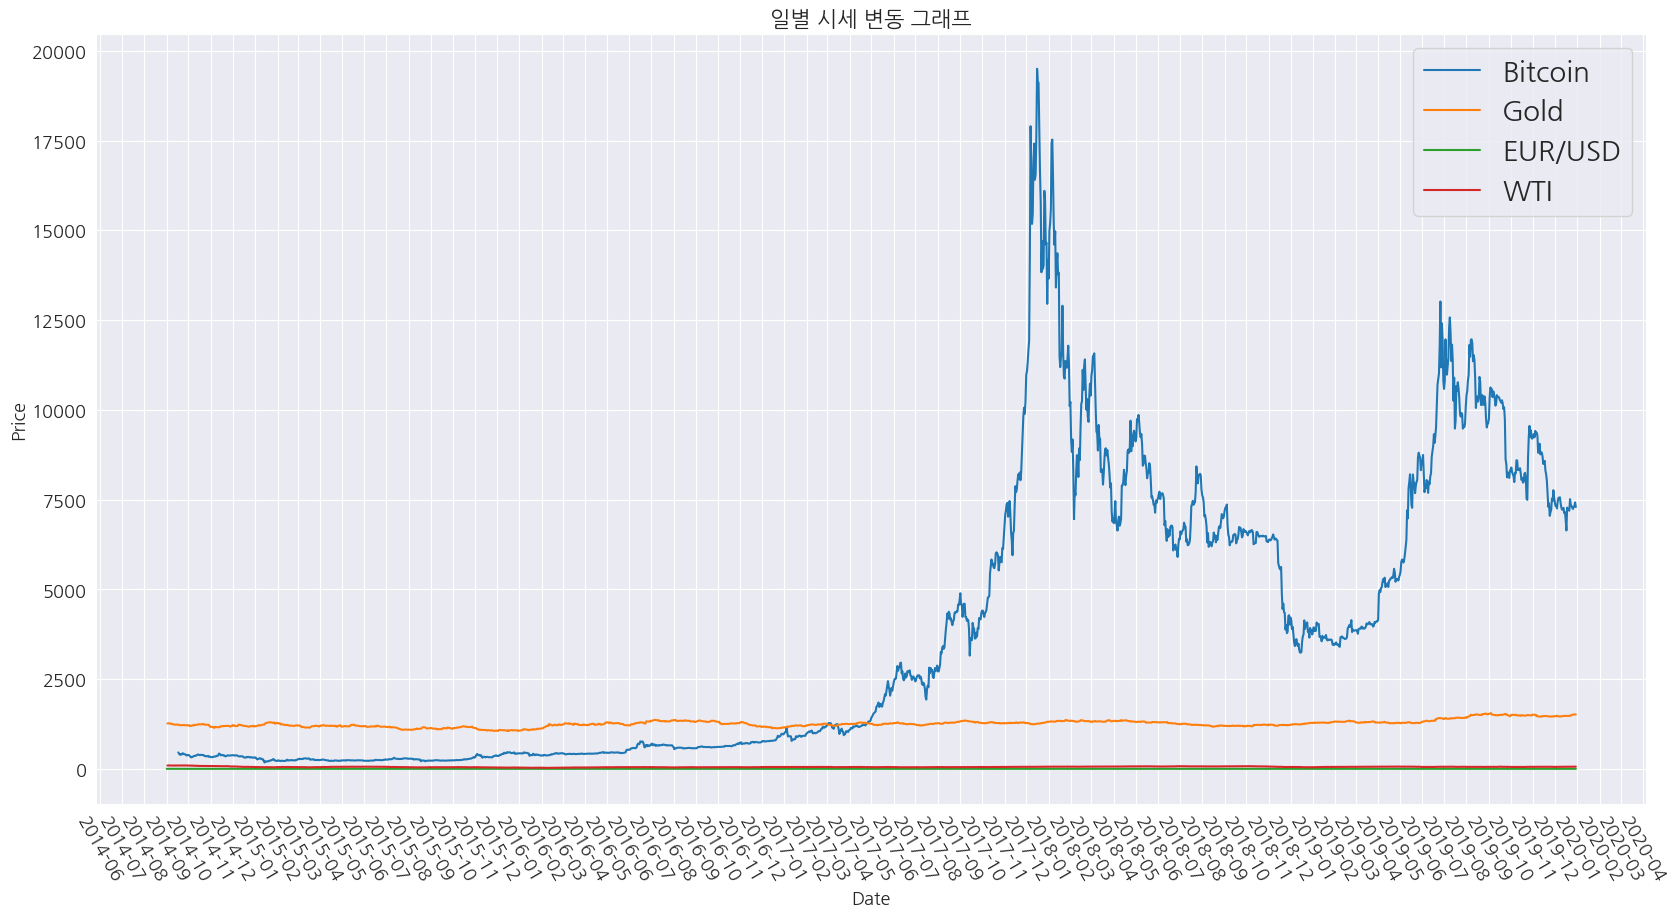

In [6]:
# daily price change graph
y1 = daily_adj_close(bitcoin, start_date, end_date)
y2 = daily_adj_close(gold, start_date, end_date)
y3 = daily_adj_close(usd, start_date, end_date)
y4 = daily_adj_close(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(y1.index, y1, label = "Bitcoin")
plt.plot(y2.index, y2, label = "Gold")
plt.plot(y3.index, y3, label = "EUR/USD")
plt.plot(y4.index, y4, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("일별 시세 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


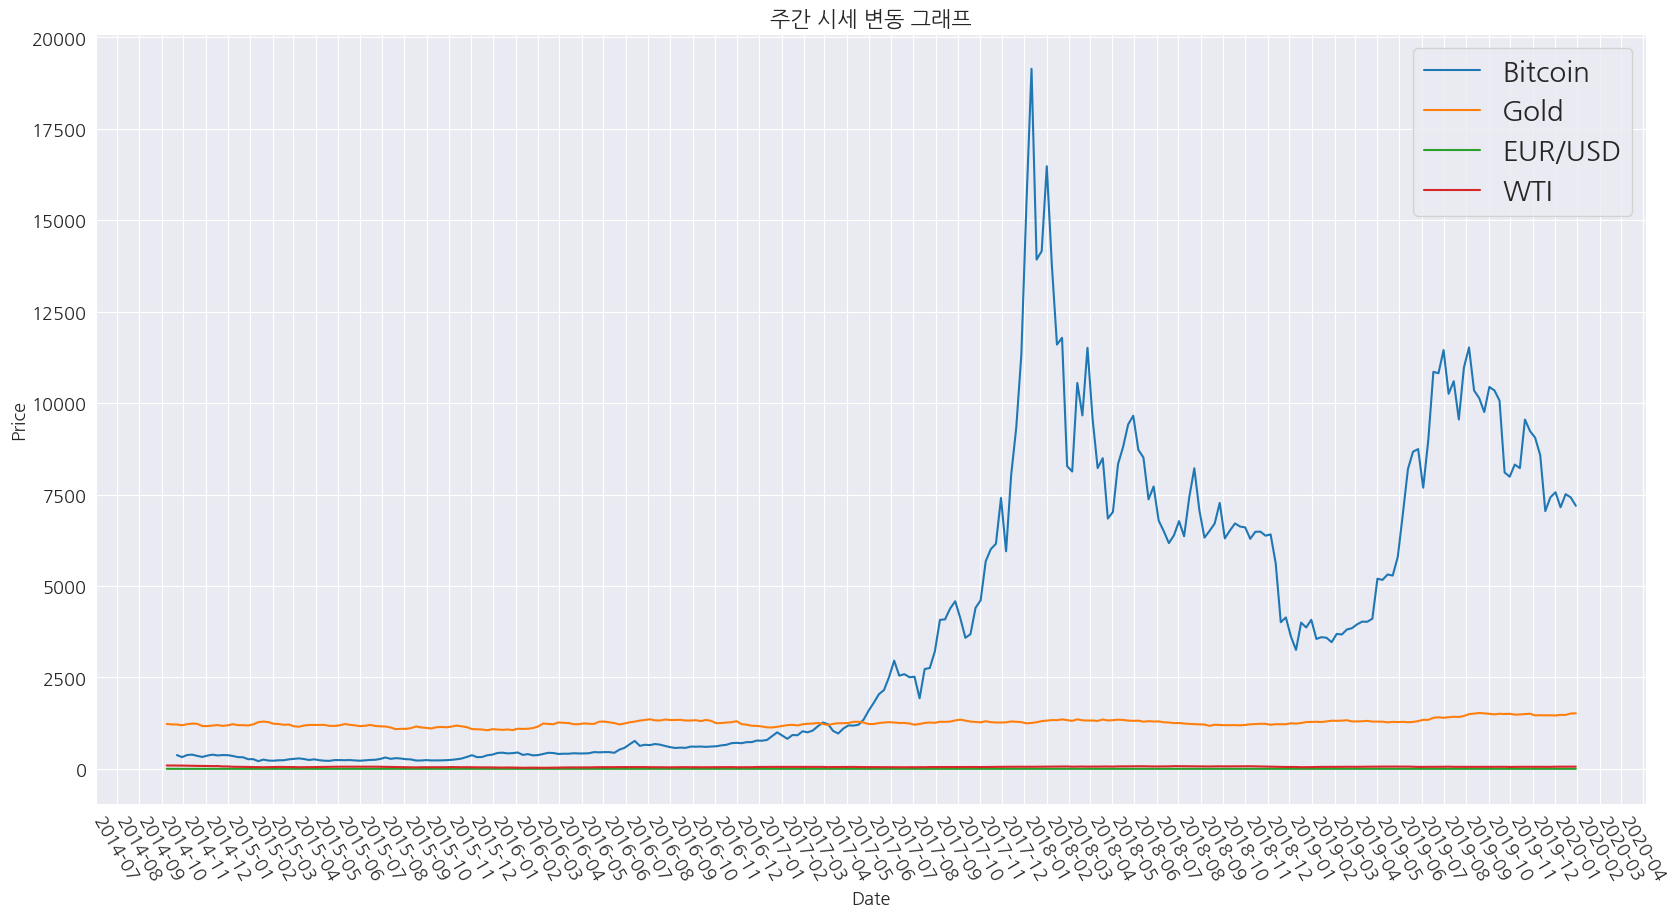

In [7]:
# weekly price change graph
y1_wk = ticker_data_wk(bitcoin, start_date, end_date)["Adj Close"]
y2_wk = ticker_data_wk(gold, start_date, end_date)["Adj Close"]
y3_wk = ticker_data_wk(usd, start_date, end_date)["Adj Close"]
y4_wk = ticker_data_wk(wti, start_date, end_date)["Adj Close"]

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(y1_wk.index, y1_wk, label = "Bitcoin")
plt.plot(y2_wk.index, y2_wk, label = "Gold")
plt.plot(y3_wk.index, y3_wk, label = "EUR/USD")
plt.plot(y4_wk.index, y4_wk, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("주간 시세 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


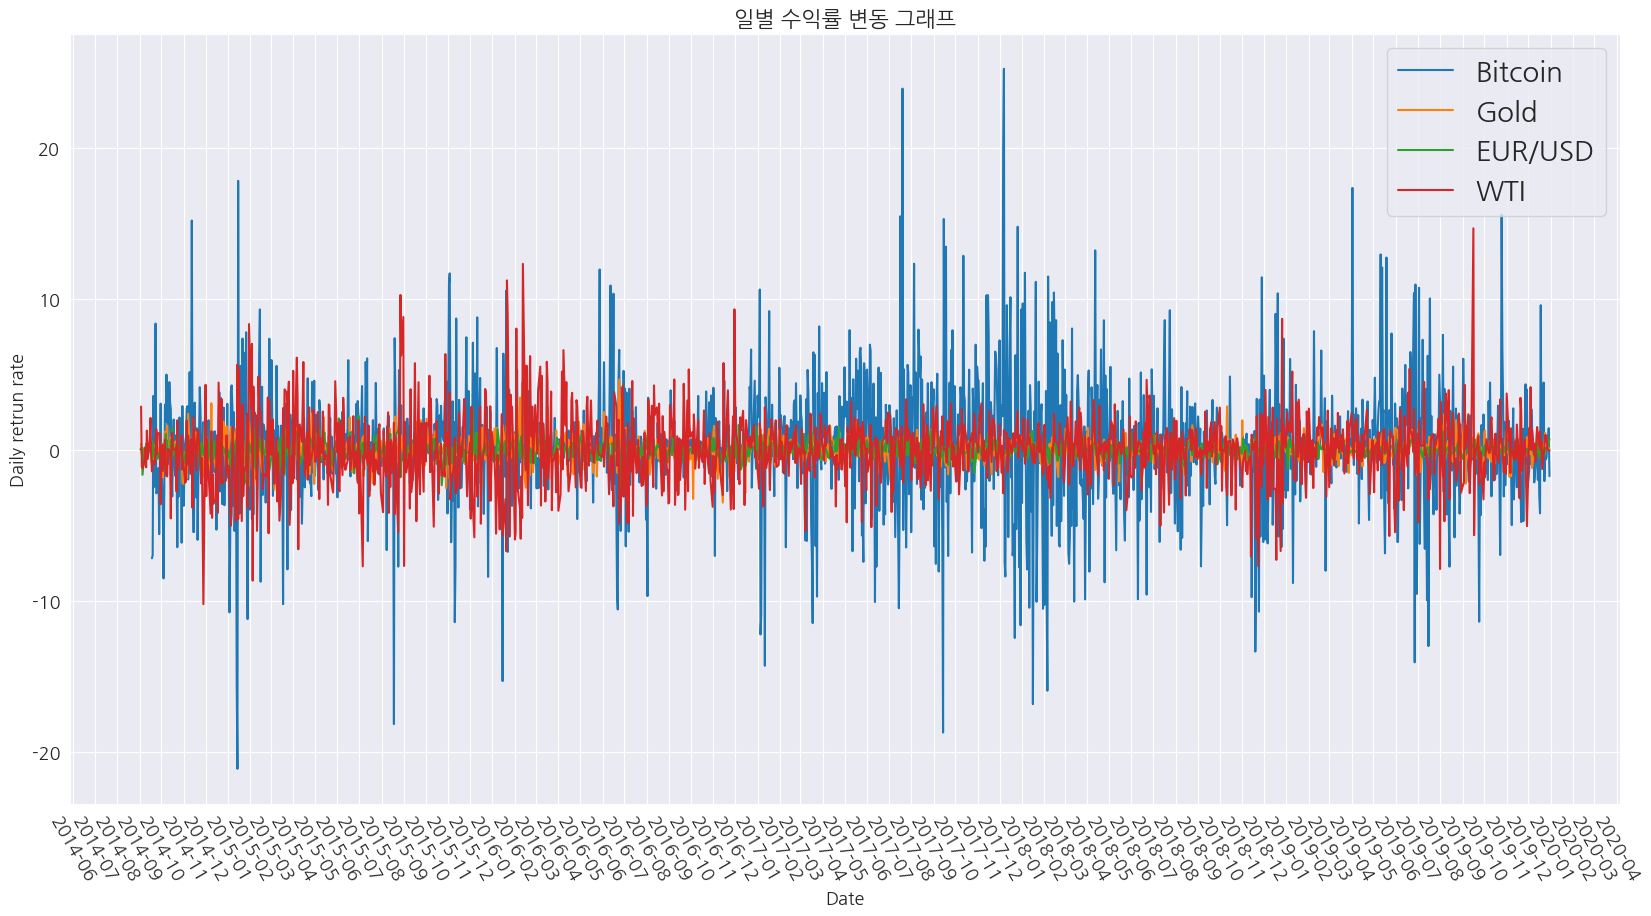

In [8]:
# daily return rate change graph
# 일별 수익률(=증감률)의 변동성 확인
d_y1 = daily_return_rate(bitcoin, start_date, end_date)
d_y2 = daily_return_rate(gold, start_date, end_date)
d_y3 = daily_return_rate(usd, start_date, end_date)
d_y4 = daily_return_rate(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(d_y1.index, d_y1, label = "Bitcoin")
plt.plot(d_y2.index, d_y2, label = "Gold")
plt.plot(d_y3.index, d_y3, label = "EUR/USD")
plt.plot(d_y4.index, d_y4, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Daily retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("일별 수익률 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


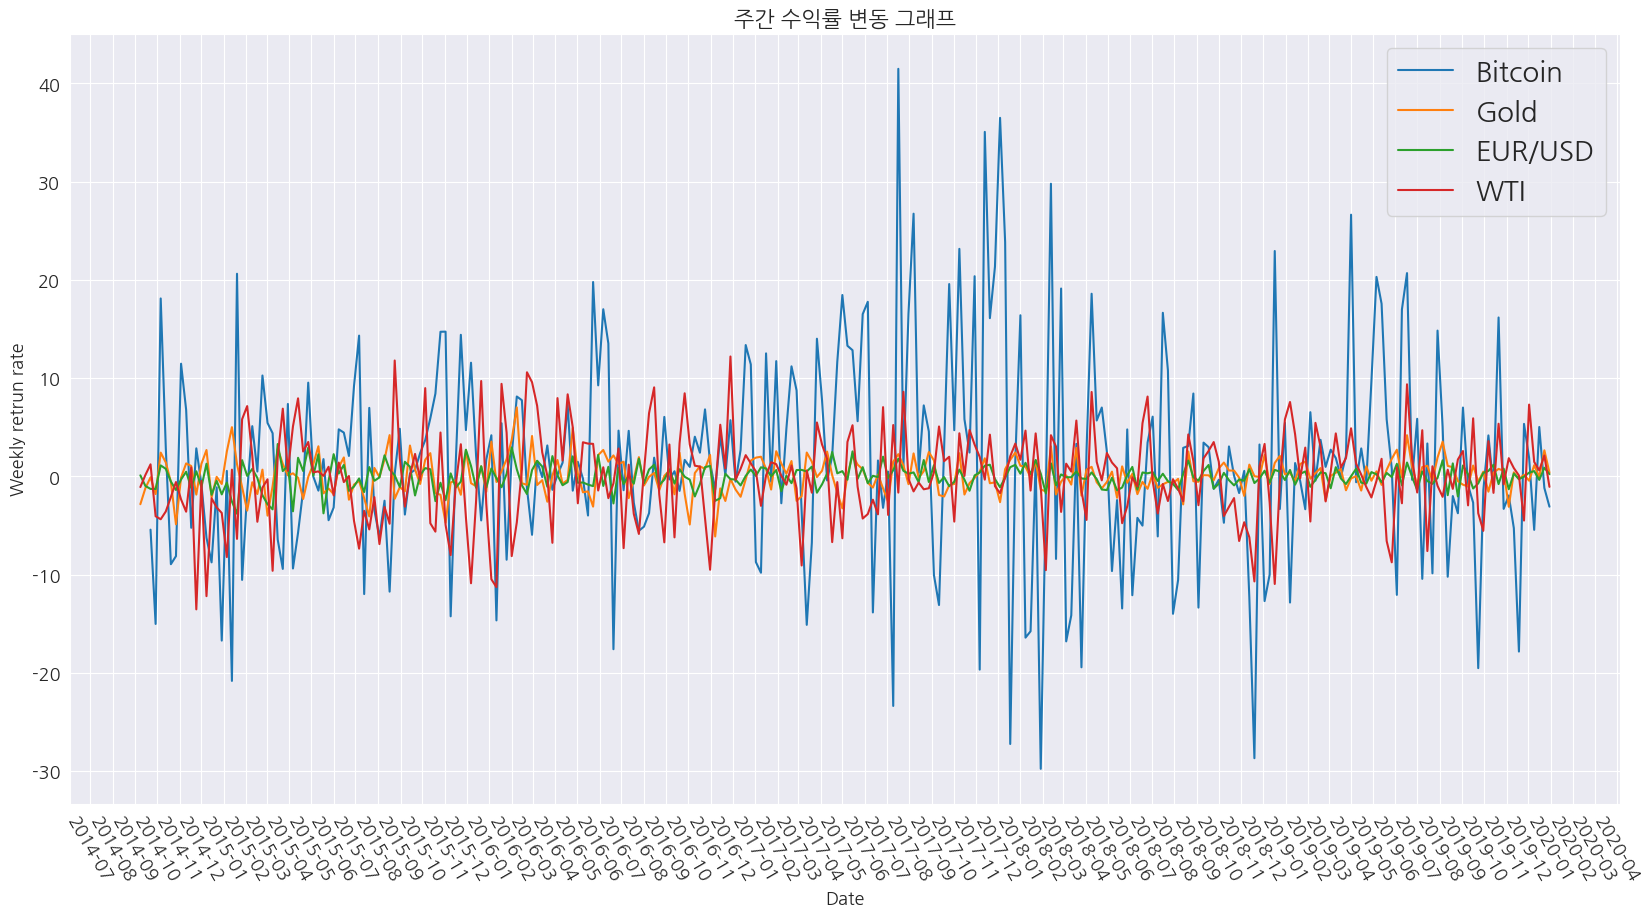

In [9]:
# weekly return rate change graph
# 주간 수익률 (=증감률)의 변동성 확인
w_y1 = weekly_return_rate(bitcoin, start_date, end_date)
w_y2 = weekly_return_rate(gold, start_date, end_date)
w_y3 = weekly_return_rate(usd, start_date, end_date)
w_y4 = weekly_return_rate(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(w_y1.index, w_y1, label = "Bitcoin")
plt.plot(w_y2.index, w_y2, label = "Gold")
plt.plot(w_y3.index, w_y3, label = "EUR/USD")
plt.plot(w_y4.index, w_y4, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Weekly retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("주간 수익률 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


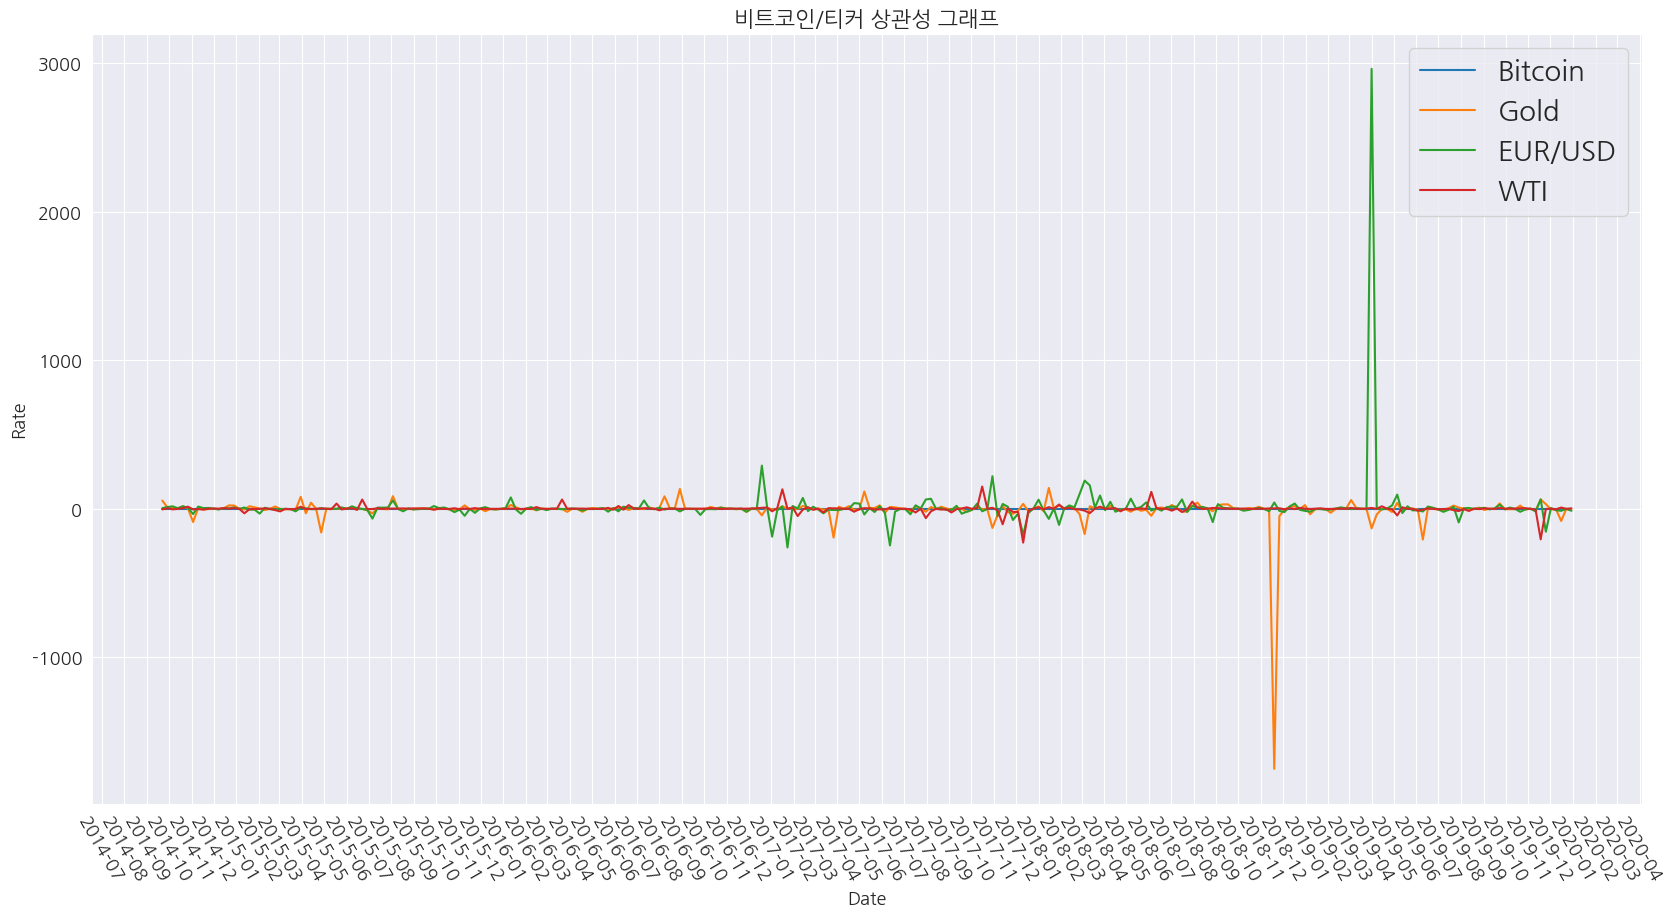

In [10]:
# 상관성 그래프 시각화
# weekly_return_rate(Bitcoin) / weekly_return_rate(ticker)
corr_y1 = corr_bit(bitcoin, start_date, end_date)
corr_y2 = corr_bit(gold, start_date, end_date)
corr_y3 = corr_bit(usd, start_date, end_date)
corr_y4 = corr_bit(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(corr_y1.index, corr_y1, label = "Bitcoin")
plt.plot(corr_y2.index, corr_y2, label = "Gold")
plt.plot(corr_y3.index, corr_y3, label = "EUR/USD")
plt.plot(corr_y4.index, corr_y4, label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("비트코인/티커 상관성 그래프")
plt.show()

## 피어슨 상관 계수
    - 각 종목들 간 상관 계수 분석
    - 상관 계수의 수치가 0.3 ~ 0.7 이면 상관관계가 있다고 봄 (약함 ~ 중간 정도의 양의 상관관계)

In [11]:
# 비트코인과 티커의 상관 계수 산출
df_close = pd.concat([bit_ticker["Adj Close"], ticker["Adj Close"]], axis = 1)
df_close.columns = ["bit_adj_close", "tk_adj_close"]
df_close = df_close.dropna()
corr_coefficient = np.corrcoef(df_close["bit_adj_close"], df_close["tk_adj_close"])[0, 1]
print(f"비트코인과의 상관 계수 : {corr_coefficient:.4f}")

비트코인과의 상관 계수 : 0.3322


### 🔥 HeatMap 생성

#### ✅ 안전자산 비교군 추가
- iShares 20+ Year Treasury Bond ETF : 미국 국채 ETF, 미국의 장기 국채에 투자하여 안정적인 수익을 추구, 종목코드 "TLT"
- Dow Jones Industrial Average : 다우존스 산업 평균 지수, 주로 대형 기업들로 구성되어 있어, 시장 전체보다는 주로 대형주 및 산업을 대표, 종목코드 "^DJI"
- Gold ETF : 나스닥 100 지수를 추종하는 ETF, 금 가격에 연동되어 금에 투자하는 효과를 제공하는 ETF, 종목코드 "GLD"

#### ✅ 위험자산 비교군 추가
- 브렌트유 :  종목코드 "BZ=F"
- Tesla :  종목코드 "TSLA"
- Nasdaq-100 Index : 나스닥 100 지수를 추종하는 ETF, 종목코드 "QQQ"
- Emerging Markets ETF : 중국, 인도, 브라질 등 신흥 시장의 주식에 투자하는 ETF, 종목코드 "EEM"

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


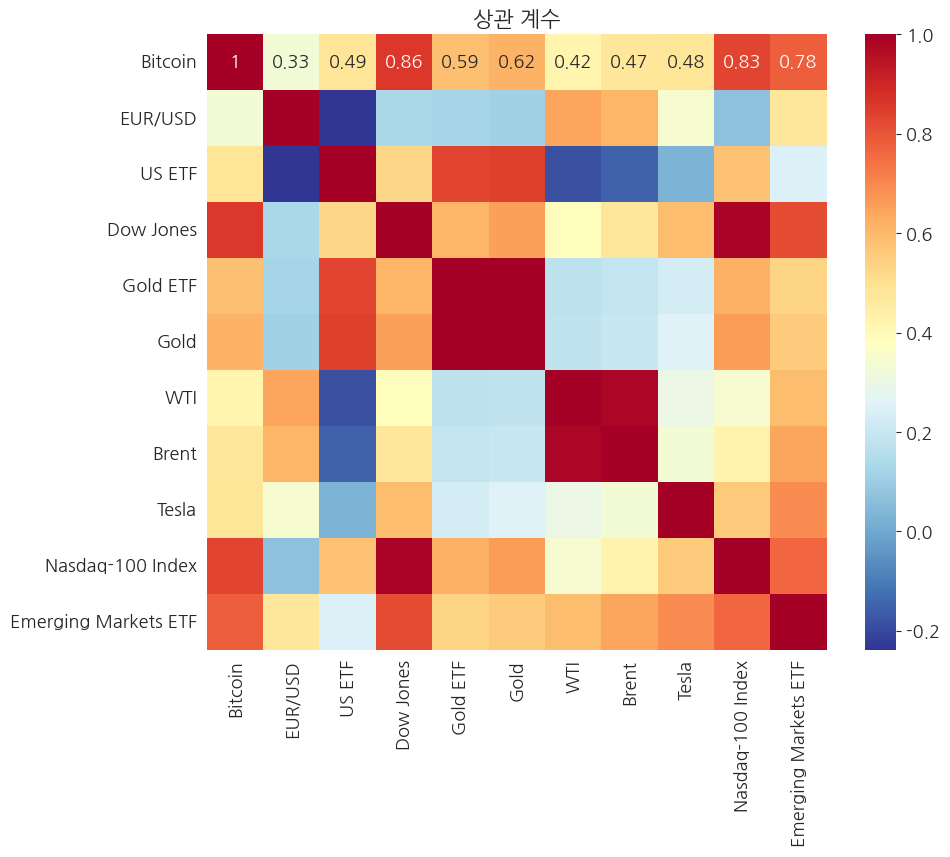

In [12]:
# 상관 계수 시각화 - HeatMep
corr_matrix = pd.DataFrame({"Bitcoin" : daily_adj_close(bitcoin, start_date, end_date),
                            # 안전자산
                            "EUR/USD" : daily_adj_close(usd, start_date, end_date),
                            "US ETF" : daily_adj_close("TLT", start_date, end_date),
                            "Dow Jones" : daily_adj_close("^DJI", start_date, end_date),
                            "Gold ETF" : daily_adj_close("GLD", start_date, end_date),
                            "Gold" : daily_adj_close(gold, start_date, end_date),
                            # 위험자산
                            "WTI" : daily_adj_close(wti, start_date, end_date),
                            "Brent" : daily_adj_close("BZ=F", start_date, end_date),
                            "Tesla" : daily_adj_close("TSLA", start_date, end_date),
                            "Nasdaq-100 Index" : daily_adj_close("QQQ", start_date, end_date),
                            "Emerging Markets ETF" : daily_adj_close("EEM", start_date, end_date)}).corr()

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = "RdYlBu_r", cbar = True)
plt.title("상관 계수")
plt.show()

## 뉴스 크롤링
- 티커의 변동성이 큰 날짜와 특정 날짜의 네이버 뉴스 크롤링
- 제도 편입 전은 "비트코인" 키워드만 크롤링

In [13]:
# 비트코인 주간 티커 데이터 수집
ticker_wk = ticker_data_wk(bitcoin, start_date, end_date)
ticker_wk

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,weekly_return
Date,,,,,,,
2014-09-22,399.100006,441.557007,374.332001,377.181000,377.181000,186772600,-5.425997
2014-09-29,376.928009,391.378998,289.295990,320.510010,320.510010,276657896,-15.024879
2014-10-06,320.389008,382.726013,302.559998,378.549011,378.549011,341152804,18.108327
2014-10-13,377.920990,411.697998,368.897003,389.545990,389.545990,156902070,2.905034
2014-10-20,389.230988,392.645996,342.877014,354.704010,354.704010,113691800,-8.944253
...,...,...,...,...,...,...,...
2019-12-02,7424.036133,7743.431641,7170.922852,7564.345215,7564.345215,121327747581,1.886412
2019-12-09,7561.795410,7618.091797,6924.375977,7152.301758,7152.301758,122542519854,-5.447179
2019-12-16,7153.663086,7518.033203,6540.049316,7511.588867,7511.588867,165399102665,5.023377


In [14]:
# 상승, 하락이 관계 없는 주간 변동성 추출
ticker_chg_abs = (ticker_wk["weekly_return"]).abs()
# 변동성 큰 구간 TOP10
large_chg = ticker_chg_abs.sort_values(ascending = False)
top_chg = large_chg[:10]
top_chg

Date
2017-07-17    41.484697
2017-12-04    36.493219
2017-11-13    35.065478
2018-02-12    29.788911
2018-01-29    29.774315
2018-11-19    28.693137
2017-12-18    27.245469
2017-08-07    26.737278
2019-04-01    26.635444
2017-12-11    23.845389
Name: weekly_return, dtype: float64

In [15]:
# 뉴스 크롤링 날짜 추가
top_lst = top_chg.index.to_list()
news_date_list.extend(top_lst)
news_date_list

[Timestamp('2017-07-17 00:00:00'),
 Timestamp('2017-12-04 00:00:00'),
 Timestamp('2017-11-13 00:00:00'),
 Timestamp('2018-02-12 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-11-19 00:00:00'),
 Timestamp('2017-12-18 00:00:00'),
 Timestamp('2017-08-07 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2017-12-11 00:00:00')]

In [16]:
news_titles = []
search = "비트코인"

driver = wb.Chrome()
driver.maximize_window()
for i in tqdm(range(len(news_date_list))) :
    # 뉴스 검색 기간 : 지정된 날짜 포함 일주일
    news_ds = news_date_list[i]
    news_de = news_ds + datetime.timedelta(days = 6)
    driver.get(f"https://search.naver.com/search.naver?where=news&query={search}&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds={news_ds.strftime('%Y.%m.%d')}&de={news_de.strftime('%Y.%m.%d')}&docid=&related=0&mynews=0&office_type=0&office_section_code=0")
    
    body = driver.find_element(By.TAG_NAME, "body")
    try :
        # 스크롤
        for _ in range(10) :
            body.send_keys(Keys.END)
            time.sleep(1)
            
        # 뉴스 타이틀 수집
        titles = driver.find_elements(By.CSS_SELECTOR, "a.news_tit")
        for i in titles :
            news_titles.append(i.text)
    except Exception as e :
        print("오류 : ", e)
print("완료😇")
driver.quit()

100%|██████████| 10/10 [02:02<00:00, 12.20s/it]


완료😇


In [17]:
print(len(news_titles))
print(news_titles)

1100
['[머니S토리] 요동치는 비트코인, 앞날은?', '[기자수첩]비트코인과 청바지', "비트코인 20% 이상 급등…비트코인 양분 위험 '뚝'↓", "'운명의 날' 앞둔 비트코인, 분할 위기 벗어난 미래는", '비트코인 소폭 하락···이더리움 등 일부 종목 상승', '입출금 정지 앞두고 "현금화하자" 매물 봇물...비트코인 300만원 재붕괴', '英 글로벌 코스메틱기업 러쉬, “상품 결제수단으로 비트코인 도입 결정"', '가상화폐 비트코인 일시 조정후 300만원 다시 돌파', '[차트 분석] 폴로닉스·GDAX, 비트코인 여전히 단기 상승추세 지속중', "세계 최대 다크웹 '알파베이·한사마켓' 폐쇄…비트코인은?", '[글로벌 경제] 비트코인 분열 우려…가상화폐 전망은?', '코인원 "세그윗 대비 오는 28일 비트코인 입출금 일시 중지" 공지', "비트코인 등 국내 거래 가상화폐 6종 '김치프리미엄' 실종...왜?", "'비트코인 하드포크 없을 것' 믿음 확산...반락 하루만에 상승세 전환", '비트코인 가격 회복세…문제 해결 기대감', '오늘의 가상화폐 시세(2017.7.22)...비트코인 2.41%↓·이더리움 2.66%↓', '비트코인 등 가상화폐 거래인가제 도입 추진···법제화 시동', '뉴질랜드 중앙은행 "비트코인 기술, 기존 금융시스템에도 이익"', '비트코인 하락에 채굴 열풍 시들…그래픽 카드 시장도 안정화', '[인터뷰] "분열되는 비트코인…거래 안되면 휴지조각"', '가상화폐 일제히 폭락…비트코인, 한 달 만에 40% 급락', '"비트코인, 17세기 튤립 투기 거품보다 심각"', '비트코인 가격, 2348달러로 급등···채굴업자·개발자 갈등 봉합', '가상화폐 이더리움, 사흘새 40% 급등락…비트코인 보다 변동성 심해', '"비트코인으로 아파트·오피스텔 구매한다고?"', '비트코인 300만원대 재돌파...세그윗 도입 기대감 커져', '中 비트코인 채굴 급증 GPU 대란…두 달 만에 1,000위안 급등', '코인공개로 모인 1.5조…비트코인 거품

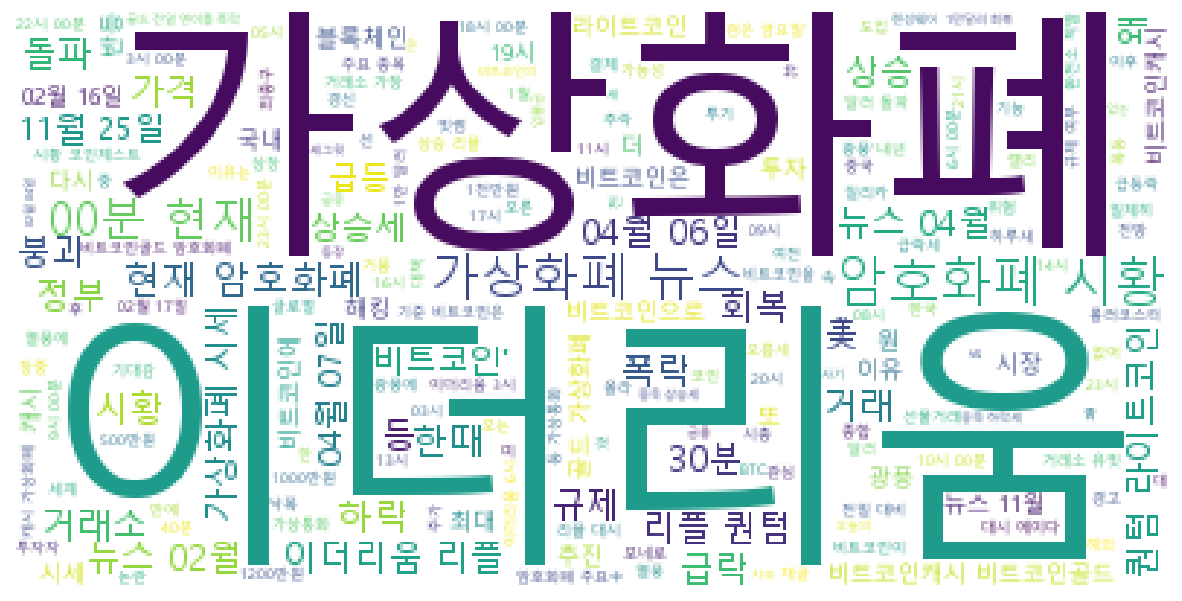

In [18]:
# 워드클라우드를 통한 핵심 키워드 시각화
text = ",".join(news_titles)
f_path = "C:\Windows\Fonts\malgun.ttf"

wc = WordCloud(font_path = f_path, random_state = 42, background_color = "white", stopwords = ["비트코인"]).generate(text)
plt.figure(figsize = (15, 10))
plt.axis("off")
plt.imshow(wc, interpolation = "None")
plt.show()